In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import PySUSSIX.f90sussix.f90sussix as f90sussix
from PySUSSIX.f90sussix.sussix import  F90Sussix

import PySUSSIX.crosssussix.crossroutines as crossroutines
import PySUSSIX.crosssussix.crosssussix as crosssussix
import PySUSSIX.crosssussix.crossref as crossref

import PySUSSIX.ducksussix.ducksussix as ducksussix

In [6]:
def cfft(z):
    size_tbt = 100000
    maxn     = len(z)
    mft      = int(np.log2(maxn))

    _z       = np.zeros(size_tbt) + 1j*np.zeros(size_tbt)
    _z[:maxn]= z
    
    f90sussix.cfft(_z,-mft)
    return _z

z = (dummy.x_sig + 1j*dummy.px_sig).values
_z = cfft(z)

In [8]:
np.max(f90sussix.cfft_out.a_out)

13183.5615234375

(-15.0, 15.0)

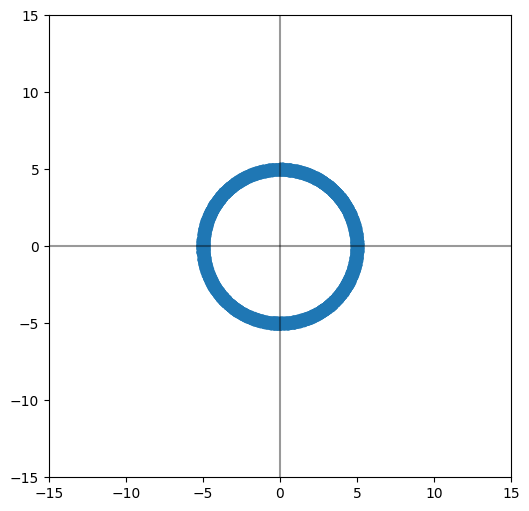

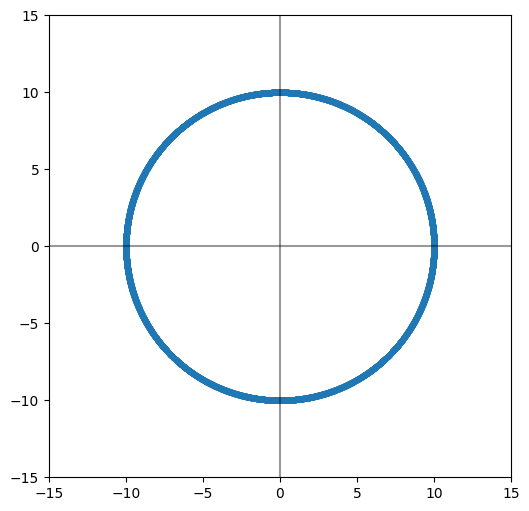

In [2]:
particle0 = pd.read_parquet('data/TEST_BUNCH_0000_XPLANE_ZETA_0.parquet')
particle1 = pd.read_parquet('data/TEST_BUNCH_0000_XPLANE_ZETA_1.parquet')

dummy = particle0.copy()


turns = int(10000)
N     = np.arange(0,turns)

Qx    = 0.31025793875089835
Qy    = 0.320264
Jx    = 0.5**2*(0.5*(10**2))
Jy    = (0.5*(10**2))
psi0  = 0#0.25

# mn = [(1,0),(-2,0)]

#  jQ_x + kQ_y + l*Q_z + m
jklm = [(0,0,0,0),(0,2,1,0)] 
aj = [np.sqrt(2*Jx),0.02*Jx,0.02*Jx,0.02*Jx]
phasors = sum([a*np.exp(2*np.pi*1j*((1-j+k)*Qx + (m-l)*Qy)*N) for (j,k,l,m),a in zip(jklm,aj)])

hx = phasors
x  = hx.real
px = hx.imag

hy = np.sqrt(2*Jy)*np.exp(-1j*(2*np.pi*Qy*N - psi0))
y  = hy.real
py = hy.imag


dummy.particle = 0
dummy.x_sig = x
dummy.px_sig = px
dummy.y_sig = y
dummy.py_sig = py


plt.figure(figsize=(6,6))
plt.plot(x,px,'.')
# plt.plot(hx.real,hx.imag,'.',ms=2)
plt.axhline(0,color='k',alpha=0.4)
plt.axvline(0,color='k',alpha=0.4)
plt.axis('square');
plt.xlim([-15,15])
plt.ylim([-15,15])

plt.figure(figsize=(6,6))
plt.plot(y,py,'.')
# plt.plot(hx.real,hx.imag,'.',ms=2)
plt.axhline(0,color='k',alpha=0.4)
plt.axvline(0,color='k',alpha=0.4)
plt.axis('square');
plt.xlim([-15,15])
plt.ylim([-15,15])


,Q,A
0,0.314811,5.117629
1,0.370377,0.186963
2,0.312945,0.041125
3,0.316678,0.041329
4,0.055566,0.026459


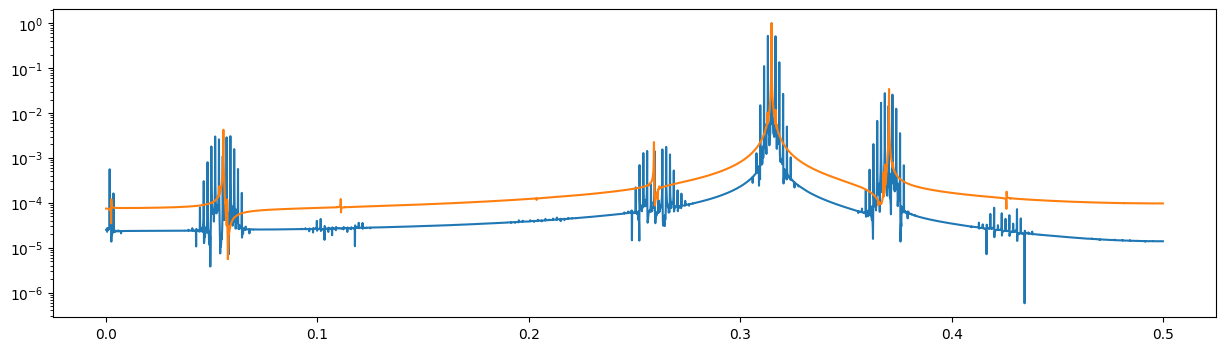

In [3]:
def get_FFT(x):
    x     = np.array(x)
    turns = np.arange(1,len(x)+1)

    freq  = np.fft.fftfreq(turns.shape[-1])
    spectrum = np.fft.fft(x-np.mean(x))

    idx      = np.argmax(np.abs(spectrum))
    Qx       = freq[idx]
    return freq[freq>0],np.abs(spectrum)[freq>0]




plt.figure(figsize=(15,4))
freq,spectrum = get_FFT(particle1.x_sig)
plt.plot(freq,spectrum/np.max(spectrum),'-')

freq,spectrum = get_FFT(particle0.x_sig)
plt.plot(freq,spectrum/np.max(spectrum),'-')
# plt.plot(Q,A/np.max(A),'o')
plt.yscale('log')

import NAFFlib
def NAFFlib_tune(x,nfreqs = 1,Hann_order=2,multiparticles = False):

    

    # No need to remove average, already done.
    if multiparticles:
        x = np.array(x)
        Q = NAFFlib.multiparticle_tunes(x, order=Hann_order)

        Q[Q<0] = np.nan
        return Q

    else:
        x        = np.array(x)
        Q,A,An  = NAFFlib.get_tunes(x, nfreqs, Hann_order)
        # Q,A      = NAFFlib.get_tunes_all(x, nfreqs, Hann_order)

        # np.abs(Ap[i]) is the amplitude
        if nfreqs ==1:
            return Q[0]
        else:
            # return Q,np.abs(Ap),np.abs(An)
            return Q,np.abs(A)
        


Q,A = NAFFlib_tune(particle0.x_sig,nfreqs=5,Hann_order=2,multiparticles = False)
pd.DataFrame({'Q':Q,'A':A})

---
# Testing main program
---

In [4]:
SS = F90Sussix()
SS.sussix_inp(nt1   = 1, 
              nt2   = len(particle0.x_sig),
              idam  = 3,
              ir    = 1,
              tunex = 0.31,
              tuney = 0.32,
              istun = None,
              nline = 0)


SS.sussix(  particle0.x_sig,particle0.px_sig,
            particle0.y_sig,particle0.py_sig,
            particle0.zeta_sig,particle0.pzeta_sig,)
df = pd.DataFrame({'ax':SS.ax,'ox':SS.ox,'ay':SS.ay,'oy':SS.oy})#,'y':y,'py':py})
# df = df[df.ox>0]
# df.sort_values('ox',inplace=True)
# df = df.reset_index(drop=True)
df.head(10)

 X TUNE DIFFERENT FROM EXPECTED
 -0.31481147556828426       0.31000000000000000     
 EXPECTED TUNE X FOUND AT LINE           2
 Y TUNE DIFFERENT FROM EXPECTED
 -0.31735353877468614       0.32000000000000001     
 EXPECTED TUNE Y FOUND AT LINE           2
 Y TUNE DIFFERENT FROM EXPECTED
  -1.8660974207716056E-003   1.0000000000000000E-003
 EXPECTED TUNE S FOUND AT LINE           2


,ax,ox,ay,oy
0,5.117726,3.148115e-01,0.130927,3.173535e-01
1,5.117774,-3.148115e-01,0.130927,-3.173535e-01
2,0.186964,3.703771e-01,0.097028,-3.148114e-01
3,0.186975,-3.703771e-01,0.097024,3.148114e-01
4,0.114162,-2.385124e-11,0.027624,3.703770e-01
5,0.041474,3.166784e-01,0.027621,-3.703770e-01
6,0.041472,-3.166784e-01,0.015792,-3.122693e-01
7,0.041379,3.129444e-01,0.015792,3.122693e-01
8,0.041375,-3.129444e-01,0.010707,-5.225744e-12
9,0.026451,-5.556555e-02,0.011567,3.678351e-01


---
# Testing subroutines
---

## spectrum

In [4]:



cross = crossroutines.spectrum(dummy.x_sig,dummy.px_sig,number_of_harmonics = 5,method = 'hanning',return_values = True)
duck = ducksussix.spectrum(dummy.x_sig,dummy.px_sig,number_of_harmonics = 5,method = 'hanning')
display('CROSS',cross)
display('DUCK',duck)

'CROSS'

,tune,zpesi
0,0.310258,5.000000e+00+6.978777e- 12j
1,-0.389490,2.500000e-01+1.869515e- 13j
2,0.310334,-1.660121e-12-1.153461e- 12j
3,0.310176,1.353238e-12-1.346130e- 13j
4,-0.242232,-8.767324e-13-4.034402e- 15j


'DUCK'

,amplitude,frequency
0,5.000000e+00+6.978777e- 12j,0.310258
1,2.500000e-01-3.975696e- 13j,-0.389490
2,-1.358933e-12-2.405760e- 12j,0.310310
3,1.164419e-14-1.297436e- 12j,-0.242294
4,-1.822203e-14-1.297595e- 12j,-0.137190


In [10]:
crossroutines.tunenewt(dummy.x_sig,0*dummy.px_sig)

(0.31025793875090096, (24999.999999341908-2.3989512664483018e-06j))

In [11]:
type(0*1J)

complex

In [13]:
type(complex(f90sussix.data.zw_out[0].real/len(x)))

complex

In [6]:
crossroutines.tunelasr(dummy.x_sig,dummy.px_sig)

(0.3102579387778248, (0.0005001000094395693+1.4397897569530925e-11j))


## tunenewt and tunelasr

In [17]:
dummy

,CHUNK,turn,particle,state,at_element,x_sig,px_sig,y_sig,py_sig,zeta_sig,pzeta_sig
174000,0,0,0,1,0,5.250000,0.000000,10.000000,0.000000,-0.000016,-0.002811
174001,0,1,0,1,0,-2.040272,4.485921,-4.272796,-9.041195,0.000019,-0.002811
174002,0,2,0,1,0,-3.588459,-3.188665,-6.348643,7.726237,0.000055,-0.002811
174003,0,3,0,1,0,4.656971,-2.324784,9.698087,2.438669,0.000090,-0.002810
174004,0,4,0,1,0,0.047992,5.081109,-1.938947,-9.810224,0.000126,-0.002809
...,...,...,...,...,...,...,...,...,...,...,...
1974995,9,9995,0,1,0,5.162086,0.948813,9.706124,-2.406482,-0.002469,0.001920
1974996,9,9996,0,1,0,-2.774436,4.041336,-6.322976,-7.747256,-0.002489,0.001891
1974997,9,9997,0,1,0,-3.000128,-3.770697,-4.302767,9.026971,-0.002508,0.001861
1974998,9,9998,0,1,0,5.013119,-1.452134,9.999945,0.033175,-0.002527,0.001832


In [4]:
print(crossroutines.tunenewt(dummy.x_sig,dummy.px_sig))
print(crossroutines.tunenewt(dummy.x_sig,0*dummy.px_sig))
print(Qx)

(0.3102579387508983, (49999.99999998262+6.978776798095439e-08j)) zf before         (2.51951707684659839E-314,0.0000000000000000)
 zfd before                        (2.50527091874863490E-314,NaN)
 zf after              (-25290.806259478279,21933.386442385527)
 zfd after             (-66040511.753324687,-164288931.82204562)

(0.31025793875090096, (24999.999999341908-2.3989512664483018e-06j))
0.31025793875089835
 zf before         (2.51951407292747167E-314,0.0000000000000000)
 zfd before                        (2.50527091874863490E-314,NaN)
 zf after              (-12645.403130064791,10966.693221286067)
 zfd after             (-33020255.880684275,-82144465.911985204)


In [3]:
crossroutines.tunenewt(dummy.x_sig,dummy.px_sig)

 zf before               (0.0000000000000000,0.0000000000000000)
 zfd before               (0.0000000000000000,0.0000000000000000)
 zf within               (0.0000000000000000,0.0000000000000000)
 zf exit              (-25290.806259478275,21933.386442385476)
 zf within               (0.0000000000000000,0.0000000000000000)
 zf exit             (-66040511.753325947,-164288931.82204485)
 zf after              (-25290.806259478275,21933.386442385476)
 zfd after             (-66040511.753325947,-164288931.82204485)
 zf within              (-25290.806259478275,21933.386442385476)
 zf exit              (-3721.1289912780148,41448.522949355342)
 zf within             (-66040511.753325947,-164288931.82204485)
 zf exit             (-203051454.29990640,-65289705.189784102)
 zf within              (-3721.1289912780148,41448.522949355342)
 zf exit               (29733.088703506834,36972.011259224419)
 zf within             (-203051454.29990640,-65289705.189784102)
 zf exit              (-202405943.7

(0.3102579387508983, (49999.99999998276+6.9980919695868e-08j))

In [22]:
crossroutines.tunenewt(dummy.x_sig,dummy.px_sig)

 zf before         (2.89747739868080633E-314,0.0000000000000000)
 zfd before                        (2.88015597837686859E-314,NaN)
 zf after              (-25290.806259478279,21933.386442385527)
 zfd after             (-66040511.753324687,-164288931.82204562)


(0.3102579387508983, (49999.99999998262+6.978776798095439e-08j))

In [3]:
print(crossroutines.tunenewt(particle0.x_sig,particle0.px_sig))
print(crossroutines.tunelasr(particle0.x_sig,particle0.px_sig))

(-0.3148114676389241, 0j) test zw              (-23401.799753104799,99460.630016004230)

(-0.31481147458177544, 0j)


In [7]:
Qx

0.31025793875089835

---
# Testing main sections of the code
---

In [3]:

part  = dummy
results = ducksussix.datspe(x       = part.x_sig, 
                            px      = part.px_sig,
                            y       = part.y_sig, 
                            py      = part.py_sig,
                            zeta    = part.zeta_sig, 
                            pzeta   = part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning')
results['x']

,amplitude,frequency
0,5.000000e+00+6.978777e- 12j,0.310258
1,2.500000e-01-3.975696e- 13j,-0.389490
2,-1.358933e-12-2.405760e- 12j,0.310310
3,1.164419e-14-1.297436e- 12j,-0.242294
4,-1.822203e-14-1.297595e- 12j,-0.137190


In [16]:
number_of_harmonics = 5
for n in range(number_of_harmonics):
    print(n)

0
1
2
3
4


In [11]:
part.px_sig

174000     0.000000
174001     4.485921
174002    -3.188665
174003    -2.324784
174004     5.081109
             ...   
1974995    0.948813
1974996    4.041336
1974997   -3.770697
1974998   -1.452134
1974999    4.983302
Name: px_sig, Length: 10000, dtype: float64

In [3]:
part  = dummy
datspe_x,datspe_y,datspe_s = crosssussix.datspe(part.x_sig,part.px_sig,
                            part.y_sig,part.py_sig,
                            part.zeta_sig,part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning',return_values = True)
# ordres_x,ordres_y,ordres_s  = crosssussix.ordres(len(part.x_sig),tune_estimate = [0.31,0.32,0.0018],number_of_harmonics = 5,return_values = True)
part  = dummy
results = ducksussix.datspe(x       = part.x_sig, 
                            px      = part.px_sig,
                            y       = part.y_sig, 
                            py      = part.py_sig,
                            zeta    = part.zeta_sig, 
                            pzeta   = part.pzeta_sig,
                            number_of_harmonics = 5,method = 'hanning')
# results['x']
display('cross DATSPE X',datspe_x)
display('duck DATSPE X',results['x'])
# display('DATSPE S',datspe_s)
# display('ORDRES X',ordres_x)
# display('ORDRES Y',ordres_y)
# display('ORDRES S',ordres_s)

 zf before   (2.87942331113835300E-314,2.47848745062306440E-314)
 zfd before   (2.47848745062306440E-314,6.47225996052032973E-322)
 zf after              (-25290.806259478279,21933.386442385527)
 zfd after             (-66040511.753324687,-164288931.82204562)
 zf before               (2326.8634660090456,3982.1707001529030)
 zfd before              (-3950844.5444815024,38948115.912572227)
 zf after              (82.526098039843546,-312.35352338772856)
 zfd after               (1092984.4973888902,2186930.5307178157)
 zf before             (-1368.2499761059487,-650.70421696779340)
 zfd before              (571151.99920635310,-8116915.0776544791)
 zf after  (1.12098950584038800E-008,-7.75103929274553062E-010)
 zfd after   (1.46702305440123595E-005,3.80155104408147596E-005)
 zf before   (3.96263797588788787E-009,7.74075078231460679E-009)
 zfd before  (-2.32362011969119877E-005,4.42162479461080674E-005)
 zf after (-3.18980262172684249E-009,-4.49496968659269779E-010)
 zfd after  (1.7969773360

'cross DATSPE X'

,zxpes,txa
0,5.000000e+00+6.978777e- 12j,0.310258
1,2.500000e-01+1.869515e- 13j,-0.389490
2,-1.660121e-12-1.153461e- 12j,0.310334
3,1.353238e-12-1.346130e- 13j,0.310176
4,-8.767324e-13-4.034402e- 15j,-0.242232


'duck DATSPE X'

,amplitude,frequency
0,5.000000e+00+6.978777e- 12j,0.310258
1,2.500000e-01-3.975696e- 13j,-0.389490
2,-1.358933e-12-2.405760e- 12j,0.310310
3,1.164419e-14-1.297436e- 12j,-0.242294
4,-1.822203e-14-1.297595e- 12j,-0.137190


In [7]:
print(datspe_x.txa[0])
print(results['x'].frequency[0])
print([((1-j+k)*Qx + (m-l)*Qy) for (j,k,l,m),a in zip(jklm,aj)][0])
print(40*'-')
print(datspe_x.txa[1] +1)  
print(results['x'].frequency[1] + 1)
print([((1-j+k)*Qx + (m-l)*Qy) for (j,k,l,m),a in zip(jklm,aj)][1])

0.3102579387508983
0.3102579387508983
0.31025793875089835
----------------------------------------
0.610509816252695
0.6105098162526951
0.6105098162526951


In [3]:

def hanning_window(n, order=1):
    window = 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(n) / (n - 1))
    for _ in range(order - 1):
        window = 0.5 - 0.5 * np.cos(2 * np.pi * window / (n - 1))
    return window

def tunenewt(x,px,hanning_order = 1):
    """COMPUTES THE TUNE USING A DISCRETE VERSION OF LASKAR METHOD.
        IT INCLUDES A NEWTON METHOD FOR THE SEARCH OF THE FREQUENCY."""

    # Estimation of Tune with FFT
    maxn = len(x)
    mft = int(np.log2(maxn))
    npoint = 2**mft
    maxn2 = maxn // 2
    step = 2 * np.pi / maxn

    mf_values = np.arange(1, maxn + 1)
    window = hanning_window(maxn, order=hanning_order)
    # z = (x + 1j * px) * window
    z = (x + 1j * px) * (1.0 + np.cos(step * (mf_values - maxn2)))
    zsing = np.fft(z, n=-mft)


    # Search for maximum in Fourier spectrum
    ftmax = np.max(np.abs(zsing))
    nftmax = np.argmax(np.abs(zsing))
    
    tunefou = float(nftmax - 1) / float(npoint)
    if tunefou >= 0.5:
        tunefou = -(1.0 - tunefou)

    deltat = 1.0 / float(npoint)
    tune1 = tunefou - deltat

    # Call zfun
    tune = zfunr(tune, zw, zsing, maxn, tune1, deltat)

    # Call zfunr function
    tune, zw = zfunr(0.0, 1.0 / maxn, x, px, maxn)

    # Return tune
    return tune
    

def zfunr(tunea1, deltat, z, maxn):
    # Initialization
    err = 1e-10
    zu = 1j

    # Divide deltat in 5 parts
    deltat /= 5.0

    # Create complex arrays
    zd = zu * np.arange(1, maxn + 1) * z
    tunetest = np.zeros(10)
    tuneval = np.zeros(10)

    # Calculate ztune1
    ztune1 = np.exp(-zu * 2 * np.pi * tunea1)
    zf = calcr(ztune1, z)
    zfd = calcr(ztune1, zd)
    dtunea1 = np.real(zf) * np.real(zfd) + np.imag(zf) * np.imag(zfd)

    num = 1
    for ntest in range(10):
        tunea2 = tunea1 + deltat
        ztune2 = np.exp(-zu * 2 * np.pi * tunea2)
        zf = calcr(ztune2, z)
        zfd = calcr(ztune2, zd)
        dtunea2 = np.real(zf) * np.real(zfd) + np.imag(zf) * np.imag(zfd)

        if dtunea1 <= 0.0 and dtunea2 >= 0.0:
            tune1, tune2, dtune1, dtune2 = tunea1, tunea2, dtunea1, dtunea2

            for ncont in range(100):
                ratio = -dtune1 / dtune2 if np.abs(dtune2) > 0 else 0.0
                tune3 = (tune1 + ratio * tune2) / (1.0 + ratio)
                ztune3 = np.exp(-zu * 2 * np.pi * tune3)
                zf = calcr(ztune3, z)
                zfd = calcr(ztune3, zd)
                dtune3 = np.real(zf) * np.real(zfd) + np.imag(zf) * np.imag(zfd)

                if dtune3 <= 0.0:
                    if tune1 == tune3:
                        break
                    tune1, dtune1 = tune3, dtune3
                else:
                    if tune2 == tune3:
                        break
                    tune2, dtune2 = tune3, dtune3

                if np.abs(tune2 - tune1) <= err:
                    break

            tunetest[num - 1] = tune3
            tuneval[num - 1] = np.abs(zf)
            num += 1

        tunea1, dtunea1 = tunea2, dtunea2

    tune = tunetest[0]
    tunevmax = tuneval[0]

    for nc in range(1, num - 1):
        if tunevmax <= tuneval[nc]:
            tunevmax = tuneval[nc]
            tune = tunetest[nc]

    ztune = np.exp(-zu * 2 * np.pi * tune)
    zw = calcr(ztune, z)

    return tune, zw

def calcr(zv, zp):
    return np.polyval(zp[::-1], zv)



x = dummy.x_sig
px = dummy.px_sig
# Estimation of Tune with FFT
maxn = len(x)
mft = int(np.log2(maxn))
npoint = 2**mft
maxn2 = maxn // 2
step = 2 * np.pi / maxn

mf_values = np.arange(1, maxn + 1)
z = (x + 1j * px).values * (1.0 + np.cos(step * (mf_values - maxn2)))
zfunr(0.3103, 1.0 / len(x), z, len(x))




(0.3104941320915292, (-563.0248944065856+1210.8842292755517j))

In [58]:
crossroutines.tunenewt(dummy.x_sig,dummy.px_sig)

(0.3102579387508983, (49999.99999998262+6.978776798095439e-08j))

In [59]:
Qx

0.31025793875089835

In [4]:
def zfunr(z,tune0):
    size_tbt    = 100000

    _z   = np.zeros(size_tbt)
    tune = 0
    zw   = complex(0,0)

    maxn = len(z)
    _z[:maxn] = z

    tunea1 = tune0
    deltat = 1.0 / maxn
    f90sussix.zfunr(tune,zw,_z,maxn,tunea1,deltat)
    print(tune,f90sussix.zfunr_out.tune_out[0],f90sussix.zfunr_out.zw_out[0])


x = dummy.x_sig
px = dummy.px_sig
# Estimation of Tune with FFT
maxn = len(x)
mft = int(np.log2(maxn))
npoint = 2**mft
maxn2 = maxn // 2
step = 2 * np.pi / maxn

mf_values = np.arange(1, maxn + 1)
z = (x + 1j * px).values #* (1.0 + np.cos(step * (mf_values - maxn2)))
zfunr(z,0.3103)

0 0.3104009651891076 (1185.1469489622502-5300.175993804718j)


/var/folders/yf/hpn77ycx7h50r6rt81q7lghr0000gn/T/ipykernel_15405/1550561742.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  _z[:maxn] = z


0.31025793875089835

In [18]:
calcr([1,2,3],[0,0,1])

array([1, 4, 9])

In [7]:


def calcr(zv, zp):
    """
    Auxiliary routine used by TUNENEWT.

    Parameters:
    - zv: complex value
    - zp: array of complex coefficients

    Returns:
    - zpp: result of the polynomial evaluation
    """
    zpp = zp[-1]

    for np in range(len(zp) - 2, 0, -1):
        zpp = zpp * zv + zp[np]

    return zpp

zv = np.exp(-1j * 2 * np.pi * 0.31)
zp = (dummy.x_sig[:5] + 1j*dummy.px_sig[:5]).values
calcr(zv,zp)

(-7.6073850024454694+18.49678112860685j)

In [47]:
zv

(-0.368124552684678-0.9297764858882513j)

In [5]:
x,px = dummy.x_sig,dummy.px_sig
x,px = particle0.x_sig,particle0.px_sig

# def calcr(tune_phasor, z):
#     return np.polyval(z[::-1], tune_phasor)


def testcalcr(x,px):
    
    ztune1 = np.exp(-1j * 2 * np.pi * 0.31)
    # zpp
    #np.array([complex(0,0)], dtype='complex', order='F')
    z      = (x + 1j * px).values
    zf     = z[-1]*0 + 1
    maxn   = len(z)


    f90sussix.calcr(ztune1,zf,z,maxn)
    print('--')
    print('--')
    print('--')

    print('python:',ducksussix.calcr(ztune1,z))
    print('sussix:',f90sussix.calcr_out.zpp_out)
    return None

testcalcr(x,px);

--
--
--
python: (-1.5533207802412132-1.2876945908120199j)
sussix: [-1.55332078-1.28769459j]


In [5]:
f90sussix.calcr_out.zpp_out

AttributeError: module 'PySUSSIX.f90sussix.f90sussix' has no attribute 'calcr_out'

In [13]:
ztune1 = np.exp(-1j * 2 * np.pi * 0.31)
z      = (x + 1j * px).values
zd     = 1j * np.arange(1, len(x) + 1) * z
def calcr(tune_phasor, z):
    return np.polyval(z[::-1], tune_phasor)

print(calcr(ztune1,z))
print(calcr(ztune1,zd))

(-1.5533207802412132-1.2876945908120199j)
(84560.4437900024+3476.213604524224j)


In [8]:
ztune1**np.arange(1,6)
# sum()

array([-0.36812455-0.92977649j, -0.72896863+0.68454711j,
        0.90482705+0.42577929j,  0.06279052-0.99802673j,
       -0.95105652+0.30901699j])

In [7]:
x,px = dummy.x_sig,dummy.px_sig
z    = (x + 1j * px).values
zu = 1j
zd = zu * np.arange(1, len(x) + 1) * z


In [13]:
zd[:3]

array([ 0.        +5.25j      , -8.9718421 -4.08054309j,
        9.5659946-10.7653758j ])

In [12]:

z[:3]

array([ 5.25      +0.j        , -2.04027154+4.48592105j,
       -3.5884586 -3.18866487j])

In [34]:
z

array([ 5.25      +0.j        , -2.04027154+4.48592105j,
       -3.5884586 -3.18866487j, ..., -3.00012838-3.77069656j,
        5.01311918-1.45213354j, -0.84877524+4.98330221j])

In [37]:
zfunr(0.31, 1/len(z), z, len(z))

(0.3101149097759907, (2364.494114040298+10601.232243917377j))

In [38]:
Qx

0.31025793875089835

In [52]:
import numpy as np
from scipy.optimize import newton

def zfun(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function
    ztune = np.exp(-1j * 2 * np.pi * tune)
    return np.polyval(z[::-1], ztune)

def zfund(tune, z, maxn):
    # Implementation of the function z(tune)
    # Modify this based on your actual function

    zd = 1j * np.arange(1, maxn + 1) * z
    ztune = np.exp(-1j * 2 * np.pi * tune)
    return np.polyval(zd[::-1], ztune)

def equation_to_solve(tune, z, maxn):
    # The equation to solve using Newton's method
    return zfun(tune, z, maxn)

# Initial guess for the tune
initial_guess = 0.3103

# Additional arguments to pass to the function and its derivative
x,px = dummy.x_sig,dummy.px_sig
z    = (x + 1j * px).values
args = (z, len(z))

# Tolerance for convergence
tolerance = 1e-10

# Use Newton's method with specified tolerance
result_tune = newton(zfun, initial_guess,fprime=zfund, args=args)

# Now result_tune contains the tuned value of the tune
print("Tuned Tune:", result_tune)

RuntimeError: Failed to converge after 50 iterations, value is (0.31022499177146423+0.0051195234248250674j).

In [21]:
def cfft(z):
    size_tbt = 100000
    maxn     = len(z)
    mft      = int(np.log2(maxn))

    _z       = np.zeros(size_tbt) + 1j*np.zeros(size_tbt)
    _z[:maxn]= z
    
    f90sussix.cfft(_z,-mft)
    return _z

_z = cfft(z)

In [22]:
z

array([ 5.25      +0.j        , -2.04027154+4.48592105j,
       -3.5884586 -3.18866487j, ..., -3.00012838-3.77069656j,
        5.01311918-1.45213354j, -0.84877524+4.98330221j])

In [23]:
_z

array([ 5.25      +0.j        , -2.04027154+4.48592105j,
       -3.5884586 -3.18866487j, ...,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])

In [16]:
f90sussix.cfft_out.a_out

array([3.0356741 , 3.03461075, 3.03367257, ..., 0.        , 0.        ,
       0.        ])

In [7]:
z

NameError: name 'z' is not defined

In [15]:
def cfft(z):
    size_tbt = 100000
    maxn     = len(z)
    mft      = int(np.log2(maxn))

    _z       = np.zeros(size_tbt) + 1j*np.zeros(size_tbt)
    _z[:maxn]= z
    
    f90sussix.cfft(_z,-mft)
    
    return f90sussix.cfft_out.a_out



def tunenewt(x,px,hanning_order = 1):
    """COMPUTES THE TUNE USING A DISCRETE VERSION OF LASKAR METHOD.
        IT INCLUDES A NEWTON METHOD FOR THE SEARCH OF THE FREQUENCY."""

    # Estimation of Tune with FFT
    maxn = len(x)
    mft = int(np.log2(maxn))
    npoint = 2**mft
    maxn2 = maxn // 2
    step = 2 * np.pi / maxn

    mf_values = np.arange(1, maxn + 1)


    z = (x + 1j *px).values * (1.0 + np.cos(step * (mf_values - maxn2)))


    # Search for maximum in Fourier spectrum
    zsing = crossroutines.cfft(z)
    ftmax = np.max(np.abs(zsing[:npoint]))
    nftmax = np.argmax(np.abs(zsing[:npoint]))
    
    tunefou = float(nftmax ) / float(npoint)
    
    if tunefou >= 0.5:
        tunefou = -(1.0 - tunefou)
    deltat = 1.0 / float(npoint)

    
    tune1 = tunefou - deltat
    
    
    # Call zfun
    tune,zw = crossroutines.zfunr(z,tune1)

    return tune,zw

x,px = dummy.x_sig,dummy.px_sig
print(tunenewt(x,px))
print(f'({Qx})')



 A1            (0.238162160,1.65394080)
 A2            (0.237567306,1.65453088)
(0.3104941320915292, (-563.0248944065856+1210.8842292755517j))
(0.31025793875089835)


In [12]:
1/len(x)

0.0001

In [14]:
z
# f90sussix.cfft

array([ 5.25      +0.j        , -2.04027154+4.48592105j,
       -3.5884586 -3.18866487j, ..., -3.00012838-3.77069656j,
        5.01311918-1.45213354j, -0.84877524+4.98330221j])

In [6]:
crossroutines.zfunr(z,0.31018066406250000)

(0.31025793877782487, (50000.23846049943+0.1531230272901785j))

In [15]:
z

array([ 5.25      +0.j        , -2.04027154+4.48592105j,
       -3.5884586 -3.18866487j, ..., -3.00012838-3.77069656j,
        5.01311918-1.45213354j, -0.84877524+4.98330221j])

In [14]:
cfft(z)

array([ 5.25      +0.j        , -2.04027154+4.48592105j,
       -3.5884586 -3.18866487j, ...,  0.        +0.j        ,
        0.        +0.j        ,  0.        +0.j        ])

In [ ]:
0.31025793875089835
0.3102579387508983
0.3102579387509009
0.31025793877782487
0.3102579391202838


In [7]:
z[0]

(5.25+0j)

In [4]:
x,px = dummy.x_sig,dummy.px_sig
z = (x + 1j * px).values

crossroutines.tunenewt(x,px)


 zsing        (1.036308390E-06,0.00000000)
 mft          13


(0.3102579387508983, (49999.99999998262+6.978776798095439e-08j))

 zsing post            (0.238162160,1.65394080)
 zsing max   42947.628906250000     
 zfunr_input tune   0.0000000000000000     
 zfunr_input zw               (0.0000000000000000,0.0000000000000000)
 zfunr_input tune1  0.31018066406250000     
 zfunr_input z[0]         (1.03630842823720926E-006,0.0000000000000000)
 zfunr_input deltat   1.2207031250000000E-004


In [7]:
21474.19*2

42948.38